### Here, we combine the training data from the four states WI, MA, GA and NC and create a combined model
- We consider the OLS linear regression, Adaboost, Random forest and xgboost models.
- We also perform some hyperparameter tuning on the xgboost model.
- The best hyperparameters: n_estimators = 800, max_depth = 3 and learning_rate = 0.1
- We do PCA with n-components=0.95 to this hyperparameter tuned model to create another model.
- PCA(n-components=0.95) reduces 17 features to 9 principal components
### Summarizing RMSE's on 5-Fold cross-validation of the various models:
- Baseline ("take average and call it a day" model): 19.435566170780614
- OLS linear regression (sklearn): 14.559055991158607
- Adaboost model (sklearn): 12.906395048789772
- Random forest model (sklearn): 10.953117282796535
- Xgboost model (w/o hyperparameter tuning): 10.699680617050998
- Xgboost model (with hyperparameter tuning): 10.315455038470585
- Xgboost model (hyperparameter tuning + PCA): 10.577576425033437
### Summarizing R-squared score on 5-fold cross-validation of the various models
- Baseline ("take average and call it a day" model): -0.0039697246545322695
- OLS linear regression (sklearn): 0.43643944317214933
- Adaboost model (sklearn): 0.5571093080817437
- Random forest model (sklearn): 0.6807484011328917
- Xgboost model (w/o hyperparameter tuning): 0.695064708859438
- Xgboost model (with hyperparameter tuning): 0.7165536140697122
- Xgboost model (hyperparameter tuning + PCA): 0.7024763474801394
### Top five features according to SHAP, with their mean |SHAP_value| on the hyperparameters tuned xgboost model:
- Per capita income: 12.272074
- closest_five_landgrnt_avg: 2.458358
- Population: 2.347372
- closest_five_public_avg: 1.697704
- closest_five_private_nfp_avg: 1.687542
### We choose the xgboost model with PCA as our final model because it's performance is almost as good as the xgboost model without PCA, but potentially more efficient because of the reduction of the features.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style('whitegrid')

In [2]:
wi_training = pd.read_csv('data/Wisconsin/train_test_split/training.csv')
ma_training = pd.read_csv('data/Massachusetts/train_test_split/training.csv')
ga_training = pd.read_pickle('data/GA_pickled/training.pkl')
nc_training = pd.read_csv('data/North_Carolina/train_test_split/training.csv')

In [3]:
features = list(wi_training.columns[9:])
relevantcolumns = ['COUNTY','PERCENT_3_OR_ABOVE']+features
len(relevantcolumns)

19

In [8]:
ga_training.rename(columns={'closest_five_avg_dormrooms_landgrnt':'closest_five_avg_dormrooms_landgrant','closest_five_landgrant_avg':'closest_five_landgrnt_avg','closest_five_avg_enrollment_landgrant':'closest_five_avg_enrollment_landgrnt'},inplace=True)

In [9]:
ga_training.columns

Index(['SCHOOL_DSTRCT_NM', 'TEST_CMPNT_TYP_NM', 'EXAM_COUNT',
       'EXAMS_3_OR_ABOVE', 'Year', 'PERCENT_3_OR_ABOVE', 'COUNTY', 'Latitude',
       'Longitude', 'population', 'closest_five_r1r2_avg',
       'closest_five_public_avg', 'closest_five_private_nfp_avg',
       'closest_five_landgrnt_avg', 'closest_five_stem_avg',
       'closest_five_avg_enrollment_r1r2',
       'closest_five_avg_enrollment_public',
       'closest_five_avg_enrollment_private_nfp',
       'closest_five_avg_enrollment_landgrnt',
       'closest_five_avg_enrollment_stem', 'closest_five_avg_dormrooms_r1r2',
       'closest_five_avg_dormrooms_public',
       'closest_five_avg_dormrooms_private_nfp',
       'closest_five_avg_dormrooms_landgrant',
       'closest_five_avg_dormrooms_stem', 'per_capita_income'],
      dtype='object')

In [10]:
nc_training.rename(columns={'closest_five_private_notprofit_avg':'closest_five_private_nfp_avg','County':'COUNTY'},inplace=True)

In [11]:
wi_training=wi_training[relevantcolumns]
ma_training=ma_training[relevantcolumns]
ga_training=ga_training[relevantcolumns]
nc_training=nc_training[relevantcolumns]

In [12]:
nc_training=nc_training[nc_training['PERCENT_3_OR_ABOVE'] != '*']

In [13]:
nc_training=nc_training.dropna()

In [14]:
training = pd.concat([wi_training,ma_training,ga_training,nc_training],axis=0)

**Combining the training data from the four states, we create the training data for the combined model.**

In [15]:
training = training.apply(pd.to_numeric, errors='coerce')

In [16]:
training

,COUNTY,PERCENT_3_OR_ABOVE,population,per_capita_income,closest_five_r1r2_avg,closest_five_public_avg,closest_five_private_nfp_avg,closest_five_landgrnt_avg,closest_five_stem_avg,closest_five_avg_enrollment_r1r2,closest_five_avg_enrollment_public,closest_five_avg_enrollment_private_nfp,closest_five_avg_enrollment_landgrnt,closest_five_avg_enrollment_stem,closest_five_avg_dormrooms_r1r2,closest_five_avg_dormrooms_public,closest_five_avg_dormrooms_private_nfp,closest_five_avg_dormrooms_landgrant,closest_five_avg_dormrooms_stem
0,NaN,58.508604,65586.0,52266.0,102.934660,49.119866,54.126134,149.798787,93.728419,28789.0,18208.8,2322.8,29555.6,22189.6,5812.6,2876.2,659.4,5587.6,4480.6
1,NaN,42.187500,16631.0,42307.0,93.067423,37.142154,30.704517,165.243556,91.579850,28789.0,16490.0,1105.8,40912.2,23072.4,5812.6,2271.8,580.6,8589.0,5085.2
2,NaN,59.333333,23688.0,49996.0,96.378027,36.954639,42.626467,159.078732,94.292621,28789.0,16490.0,1801.8,29555.6,22189.6,5812.6,2271.8,514.8,5587.6,4480.6
3,NaN,75.934136,90998.0,83681.0,62.268640,26.951514,18.219438,147.796071,47.660966,27215.0,13718.0,2760.4,30553.4,23576.2,5328.0,727.4,737.4,8082.0,4383.4
4,NaN,68.906752,91613.0,86875.0,62.268640,26.951514,18.219438,147.796071,47.660966,27215.0,13718.0,2760.4,30553.4,23576.2,5328.0,727.4,737.4,8082.0,4383.4
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
223,NaN,70.000000,19383.0,54915.0,137.926921,28.720862,37.577446,183.704575,137.926921,30033.8,5018.6,1433.2,24107.2,30033.8,6650.8,178.2,814.4,6481.0,6650.8
224,NaN,69.512195,33046.0,48333.0,131.307585,38.818306,40.054315,178.329454,131.307585,30916.8,6888.4,2391.2,24107.2,30916.8,6860.6,910.4,1802.2,6481.0,6860.6
227,NaN,65.241295,227214.0,49313.0,91.741941,29.883256,24.596159,183.714823,91.741941,22496.4,15354.6,872.0,24885.2,22496.4,6242.6,1207.8,524.6,6909.0,6242.6
228,NaN,56.060606,99799.0,40777.0,129.024685,33.206873,39.224774,197.321227,129.024685,25475.8,4846.0,2406.8,24107.2,25475.8,5874.8,0.0,835.4,6481.0,5874.8


In [17]:
from sklearn.model_selection import train_test_split
train, validation = train_test_split(training, test_size = 0.2, random_state = 226)

In [18]:
import xgboost as xgb
from sklearn.ensemble import RandomForestRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import AdaBoostRegressor
import joblib
from sklearn.model_selection import KFold
from sklearn.metrics import root_mean_squared_error
from sklearn.metrics import r2_score
from sklearn.linear_model import LinearRegression

N_CORES = joblib.cpu_count(only_physical_cores=True)

In [19]:
num_splits = 5
num_models = 5
kfold = KFold(num_splits,
              random_state = 226,
              shuffle=True)
## This array will hold the rmse for each model and split
rmses = np.zeros((num_models, num_splits))
rsquared = np.zeros((num_models, num_splits))

## sets a split counter
i = 0

## loop through the kfold here
for train_index, test_index in kfold.split(training):
    ## cv training set
    train_data = training.iloc[train_index]
    
    ## cv holdout set
    holdout_data = training.iloc[test_index]
    
    ## "Fit" and get ho mse for the baseline model

    baseline_pred = train_data['PERCENT_3_OR_ABOVE'].mean()*np.ones(len(holdout_data))
    
    rmses[0, i] = root_mean_squared_error(holdout_data['PERCENT_3_OR_ABOVE'], baseline_pred)
    rsquared[0, i] = r2_score(holdout_data['PERCENT_3_OR_ABOVE'], baseline_pred)
    
    ## Fit and get ho mse for Adaboost model
    dtree_reg = DecisionTreeRegressor(max_depth=4)

    ada_reg = AdaBoostRegressor(DecisionTreeRegressor(max_depth=4), n_estimators=300, random_state=226)

    ada_reg.fit(train_data[features], train_data['PERCENT_3_OR_ABOVE'])
    
    rmses[1, i] = root_mean_squared_error(holdout_data['PERCENT_3_OR_ABOVE'], ada_reg.predict(holdout_data[features]))
    rsquared[1, i] = ada_reg.score(holdout_data[features],holdout_data['PERCENT_3_OR_ABOVE'])
    
    
    ## Fit and get ho mse for xgboost model
    
    dtrain_reg = xgb.DMatrix(train_data[features], train_data['PERCENT_3_OR_ABOVE'], enable_categorical=True)
    dtest_reg = xgb.DMatrix(holdout_data[features],holdout_data['PERCENT_3_OR_ABOVE'],enable_categorical=True)

    params = {"objective": "reg:squarederror", "tree_method": "hist"}   ## "hist" uses cpu to compute the model
    n = 800

    evals = [(dtrain_reg, "train"), (dtest_reg, "validation")]

    xgb_model = xgb.train(
    params=params,
    dtrain=dtrain_reg,
    num_boost_round=n,
    evals=evals,
    verbose_eval=10,            # Print rmse val every 10 rounds
    early_stopping_rounds=100   # XGBoost will automatically stop the training if validation loss doesn't improve for 100 consecutive rounds
    )

    y_pred = xgb_model.predict(dtest_reg)
    rmses[2,i] = root_mean_squared_error(holdout_data['PERCENT_3_OR_ABOVE'],y_pred)
    rsquared[2, i] = r2_score(holdout_data['PERCENT_3_OR_ABOVE'], y_pred)

    
    ## Fit and get ho mse for Random Foret model
    random_forest = RandomForestRegressor(min_samples_leaf=5, random_state=0, n_jobs=N_CORES)
    random_forest.fit(train_data[features],train_data['PERCENT_3_OR_ABOVE'])
    
    rmses[3, i] = root_mean_squared_error(holdout_data['PERCENT_3_OR_ABOVE'], random_forest.predict(holdout_data[features]))
    rsquared[3, i] = r2_score(holdout_data['PERCENT_3_OR_ABOVE'], random_forest.predict(holdout_data[features]))

    ## Fit and get ho mse for full model
    full_lr = LinearRegression()
    full_lr.fit(train_data[features],train_data['PERCENT_3_OR_ABOVE'])
    
    rmses[4, i] = root_mean_squared_error(holdout_data['PERCENT_3_OR_ABOVE'], full_lr.predict(holdout_data[features]))
    rsquared[4, i] = full_lr.score(holdout_data[features],holdout_data['PERCENT_3_OR_ABOVE'])
    

    i = i+1


[0]	train-rmse:15.89369	validation-rmse:17.11666
[10]	train-rmse:7.50484	validation-rmse:11.68372
[20]	train-rmse:6.21552	validation-rmse:11.12839
[30]	train-rmse:5.70530	validation-rmse:11.06259
[40]	train-rmse:5.29552	validation-rmse:10.93930
[50]	train-rmse:5.00041	validation-rmse:10.86811
[60]	train-rmse:4.78079	validation-rmse:10.84159
[70]	train-rmse:4.64832	validation-rmse:10.87669
[80]	train-rmse:4.55852	validation-rmse:10.90086
[90]	train-rmse:4.49927	validation-rmse:10.90266
[100]	train-rmse:4.45808	validation-rmse:10.92128
[110]	train-rmse:4.43795	validation-rmse:10.94453
[120]	train-rmse:4.42293	validation-rmse:10.95774
[130]	train-rmse:4.40877	validation-rmse:10.95234
[140]	train-rmse:4.40142	validation-rmse:10.96657
[150]	train-rmse:4.39267	validation-rmse:10.96383
[159]	train-rmse:4.38794	validation-rmse:10.97897
[0]	train-rmse:15.93848	validation-rmse:15.81808
[10]	train-rmse:7.83403	validation-rmse:9.82112
[20]	train-rmse:6.50352	validation-rmse:9.25448
[30]	train-rmse

In [20]:
## Find the avg cv mse for each model here
print(f"Baseline Avg. CV RMSE: {np.mean(rmses[0,:])} and STD: {np.std(rmses[0,:])}")
print(f"Adaboost model Avg. CV RMSE: {np.mean(rmses[1,:])} and STD: {np.std(rmses[1,:])}")
print(f"xgboost model Avg. CV RMSE: {np.mean(rmses[2,:])} and STD: {np.std(rmses[2,:])}")
print(f"Random forest model Avg. CV RMSE: {np.mean(rmses[3,:])} and STD: {np.std(rmses[3,:])}")
print(f"fullmodel Avg. CV RMSE: {np.mean(rmses[4,:])} and STD: {np.std(rmses[1,:])}")

Baseline Avg. CV RMSE: 19.265616366553928 and STD: 0.5701578140549048
Adaboost model Avg. CV RMSE: 12.886677118267519 and STD: 0.5596669826165285
xgboost model Avg. CV RMSE: 10.311158235898342 and STD: 0.7726731496938948
Random forest model Avg. CV RMSE: 10.955812440574002 and STD: 0.6288596029657166
fullmodel Avg. CV RMSE: 14.538515236079007 and STD: 0.5596669826165285


In [21]:
## Find the avg cv R-squared score for each model here
print(f"Baseline Avg. CV score: {np.mean(rsquared[0,:])} and STD: {np.std(rsquared[0,:])}")
print(f"Adaboost Avg. CV score: {np.mean(rsquared[1,:])} and STD: {np.std(rsquared[1,:])}")
print(f"Xgboost model Avg. CV score: {np.mean(rsquared[2,:])} and STD: {np.std(rsquared[2,:])}")
print(f"Random forest model Avg. CV score: {np.mean(rsquared[3,:])} and STD: {np.std(rsquared[3,:])}")
print(f"fullmodel Avg. CV score: {np.mean(rsquared[4,:])} and STD: {np.std(rsquared[1,:])}")

Baseline Avg. CV score: -0.000693191013264105 and STD: 0.000626218178638965
Adaboost Avg. CV score: 0.5524106890347993 and STD: 0.016669338787096748
Xgboost model Avg. CV score: 0.7129697400938924 and STD: 0.03116716593434557
Random forest model Avg. CV score: 0.676508350803529 and STD: 0.020859306119717154
fullmodel Avg. CV score: 0.4303642109700053 and STD: 0.016669338787096748


### Xgboost works the best on the combined model. But random forest is not far behind.

In [22]:
X_train = train[features]
y_train = train['PERCENT_3_OR_ABOVE']
X_test = validation[features]
y_test = validation['PERCENT_3_OR_ABOVE']
dtrain_reg = xgb.DMatrix(X_train, y_train, enable_categorical=True)
dtest_reg = xgb.DMatrix(X_test,y_test,enable_categorical=True)

In [23]:
params = {"objective": "reg:squarederror", "tree_method": "hist"}   ## "hist" uses cpu to compute the model
n = 800

evals = [(dtrain_reg, "train"), (dtest_reg, "validation")]

xgb_old_model = xgb.train(
params=params,
dtrain=dtrain_reg,
num_boost_round=n,
evals=evals,
verbose_eval=10,            # Print rmse val every 10 rounds
early_stopping_rounds=100   # XGBoost will automatically stop the training if validation loss doesn't improve for 100 consecutive rounds
)
## This model is created before any hyperparameters tuning. So we name it as 'xgb_old_model'

[0]	train-rmse:15.89369	validation-rmse:17.11666
[10]	train-rmse:7.50484	validation-rmse:11.68372
[20]	train-rmse:6.21552	validation-rmse:11.12839
[30]	train-rmse:5.70530	validation-rmse:11.06259
[40]	train-rmse:5.29552	validation-rmse:10.93930
[50]	train-rmse:5.00041	validation-rmse:10.86811
[60]	train-rmse:4.78079	validation-rmse:10.84159
[70]	train-rmse:4.64832	validation-rmse:10.87669
[80]	train-rmse:4.55852	validation-rmse:10.90086
[90]	train-rmse:4.49927	validation-rmse:10.90266
[100]	train-rmse:4.45808	validation-rmse:10.92128
[110]	train-rmse:4.43795	validation-rmse:10.94453
[120]	train-rmse:4.42293	validation-rmse:10.95774
[130]	train-rmse:4.40877	validation-rmse:10.95234
[140]	train-rmse:4.40142	validation-rmse:10.96657
[150]	train-rmse:4.39267	validation-rmse:10.96383
[158]	train-rmse:4.38822	validation-rmse:10.97947


# Hyperparameters tuning for xgboost model

In [ ]:
from sklearn.model_selection import RandomizedSearchCV
from sklearn.pipeline import Pipeline
from sklearn.model_selection import GridSearchCV


In [ ]:

hyperparameter_grid = {
    'model__n_estimators': [10,100, 400, 800, 1000],
    'model__max_depth': [1,3, 6, 9, 10],
    'model__learning_rate': [0.01,0.05, 0.1, 0.20,0.3],
    }

pipeline = GridSearchCV(
    xgb.XGBRegressor(objective= 'reg:squarederror',seed = 0)
    param_grid=hyperparameter_grid,
    scoring='r2',
    n_jobs=10,
    cv=7,
    verbose=3)


**Because it takes long time to run the following code cell, we have commented out the code. Uncomment it to run it again.**

In [ ]:
# pipeline.fit(X_train, y_train)

Fitting 7 folds for each of 125 candidates, totalling 875 fits
[CV 1/7] END model__learning_rate=0.01, model__max_depth=1, model__n_estimators=100;, score=0.259 total time=   0.3s
[CV 4/7] END model__learning_rate=0.01, model__max_depth=1, model__n_estimators=100;, score=0.204 total time=   0.1s
[CV 3/7] END model__learning_rate=0.01, model__max_depth=1, model__n_estimators=100;, score=0.237 total time=   0.4s
[CV 2/7] END model__learning_rate=0.01, model__max_depth=1, model__n_estimators=10;, score=0.040 total time=   0.4s
[CV 5/7] END model__learning_rate=0.01, model__max_depth=1, model__n_estimators=100;, score=0.217 total time=   0.1s
[CV 1/7] END model__learning_rate=0.01, model__max_depth=1, model__n_estimators=10;, score=0.049 total time=   0.3s
[CV 5/7] END model__learning_rate=0.01, model__max_depth=1, model__n_estimators=10;, score=0.049 total time=   0.3s
[CV 7/7] END model__learning_rate=0.01, model__max_depth=1, model__n_estimators=100;, score=0.246 total time=   0.1s
[CV 

GridSearchCV(cv=7,
             estimator=Pipeline(steps=[('preprocessor',
                                        ColumnTransformer(remainder='passthrough',
                                                          transformers=[('freq',
                                                                         PowerTransformer(method='box-cox',
                                                                                          standardize=False),
                                                                         [0]),
                                                                        ('chord',
                                                                         KBinsDiscretizer(encode='ordinal',
                                                                                          n_bins=6,
                                                                                          strategy='kmeans'),
                                                                         [1]),
                                                                        ('vel',
                                                                         KBinsDiscretizer(encode='ordinal',
                                                                                          n_bins=4,
                                                                                          strategy='kmeans'),
                                                                         [2]),
                                                                        ('thickness',
                                                                         Quant...
                                                     max_depth=None,
                                                     max_leaves=None,
                                                     min_child_weight=None,
                                                     missing=nan,
                                                     monotone_constraints=None,
                                                     multi_strategy=None,
                                                     n_estimators=None,
                                                     n_jobs=None,
                                                     num_parallel_tree=None,
                                                     random_state=None, ...))]),
             n_jobs=10,
             param_grid={'model__learning_rate': [0.01, 0.05, 0.1, 0.2, 0.3],
                         'model__max_depth': [1, 3, 6, 9, 10],
                         'model__n_estimators': [10, 100, 400, 800, 1000]},
             scoring='r2', verbose=3)

**Alternatively, one can use `RandomizedSearchCV` for hyperparameter tuning. It will work faster, but at the tradeoff of not going through all given possibilities (so might not return the absolute optimal hyperparameters).**

In [60]:
hyperparam = pipeline.best_params_
print("The best Hyperparameters for XGBRegressor are: {}".format(hyperparam))

The best Hyperparameters for XGBRegressor are: {'model__learning_rate': 0.1, 'model__max_depth': 3, 'model__n_estimators': 800}


# Next, let us see if PCA makes our model more efficient or if we drastically lose performance.

In [36]:
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.decomposition import PCA

In [37]:
scaler = StandardScaler()
training_scaled = scaler.fit_transform(train[features])
training_scaled.shape

(1436, 17)

In [38]:
pca = PCA(0.95)
training_pca = pca.fit_transform(training_scaled)
training_pca.shape

(1436, 9)

In [39]:
xgb_pca_pipe = Pipeline([('scale', StandardScaler()), ('pca', PCA(0.95)), ('xgb_model', xgb.XGBRegressor(n_estimators=800, max_depth=3, learning_rate=0.1,objective= 'reg:squarederror'))])

In [40]:
xgb_pca_pipe.fit(train[features],train['PERCENT_3_OR_ABOVE'])

Pipeline(steps=[('scale', StandardScaler()), ('pca', PCA(n_components=0.95)),
                ('xgb_model',
                 XGBRegressor(base_score=None, booster=None, callbacks=None,
                              colsample_bylevel=None, colsample_bynode=None,
                              colsample_bytree=None, device=None,
                              early_stopping_rounds=None,
                              enable_categorical=False, eval_metric=None,
                              feature_types=None, gamma=None, grow_policy=None,
                              importance_type=None,
                              interaction_constraints=None, learning_rate=0.1,
                              max_bin=None, max_cat_threshold=None,
                              max_cat_to_onehot=None, max_delta_step=None,
                              max_depth=3, max_leaves=None,
                              min_child_weight=None, missing=nan,
                              monotone_constraints=None, multi_strategy=None,
                              n_estimators=800, n_jobs=None,
                              num_parallel_tree=None, random_state=None, ...))])

In [41]:
xgb_pca_preds = xgb_pca_pipe.predict(validation[features])
print(root_mean_squared_error(xgb_pca_preds,validation['PERCENT_3_OR_ABOVE']))
print(r2_score(validation['PERCENT_3_OR_ABOVE'],xgb_pca_preds,multioutput='variance_weighted'))

10.985688892656702
0.6891866038905241


In [42]:
xgb_new_model = xgb.XGBRegressor(n_estimators=800, max_depth=3, learning_rate=0.1,objective= 'reg:squarederror')
xgb_new_model.fit(train[features],train['PERCENT_3_OR_ABOVE'])
xgb_new_preds = xgb_new_model.predict(validation[features])
print(root_mean_squared_error(xgb_new_preds,validation['PERCENT_3_OR_ABOVE']))
print(r2_score(validation['PERCENT_3_OR_ABOVE'],xgb_new_preds,multioutput='variance_weighted'))

10.434631232575821
0.7195862226829322


In [43]:
xgb_old_preds = xgb_old_model.predict(dtest_reg)
print(root_mean_squared_error(xgb_old_preds,validation['PERCENT_3_OR_ABOVE']))
print(r2_score(validation['PERCENT_3_OR_ABOVE'],xgb_old_preds,multioutput='variance_weighted'))

10.978974875610705
0.689566401420447


### Our hyperparameter-tuned model is clearly better than the older model in terms of root mean squared error and the PCA(0.95) model is marginally behind of our old model. Analogous conclusion can be obtained from the R-squared values.
### Let us further test with 5-Fold cross validation.

In [53]:
num_splits = 5
num_models = 4
kfold = KFold(num_splits,
              random_state = 226,
              shuffle=True)
## This array will hold the rmse for each model and split
rmses = np.zeros((num_models, num_splits))
rsquared = np.zeros((num_models, num_splits))

## sets a split counter
i = 0

## loop through the kfold here
for train_index, test_index in kfold.split(training):
    ## cv training set
    train_data = training.iloc[train_index]
    
    ## cv holdout set
    holdout_data = training.iloc[test_index]
    
    ## "Fit" and get ho mse for the baseline model

    baseline_pred = train_data['PERCENT_3_OR_ABOVE'].mean()*np.ones(len(holdout_data))
    
    rmses[0, i] = root_mean_squared_error(holdout_data['PERCENT_3_OR_ABOVE'], baseline_pred)
    rsquared[0, i] = r2_score(holdout_data['PERCENT_3_OR_ABOVE'], baseline_pred)
    
    ## Fit and get ho mse for new hyperparameter tuned xgboost model
    xgb_model = xgb.XGBRegressor(n_estimators=800, max_depth=3, learning_rate=0.1,objective= 'reg:squarederror')
    xgb_model.fit(train_data[features],train_data['PERCENT_3_OR_ABOVE'])
    
    rmses[1, i] = root_mean_squared_error(holdout_data['PERCENT_3_OR_ABOVE'], xgb_model.predict(holdout_data[features]))
    xgb_preds = xgb_model.predict(holdout_data[features])
    rsquared[1, i] = r2_score(holdout_data['PERCENT_3_OR_ABOVE'],xgb_preds)
    
    
    ## Fit and get ho mse for old (not hyperparameter tuned) xgboost model
    
    dtrain_reg = xgb.DMatrix(train_data[features], train_data['PERCENT_3_OR_ABOVE'], enable_categorical=True)
    dtest_reg = xgb.DMatrix(holdout_data[features],holdout_data['PERCENT_3_OR_ABOVE'],enable_categorical=True)

    params = {"objective": "reg:squarederror", "tree_method": "hist"}   ## "hist" uses cpu to compute the model
    n = 800

    evals = [(dtrain_reg, "train"), (dtest_reg, "validation")]

    xgb_old_model = xgb.train(
    params=params,
    dtrain=dtrain_reg,
    num_boost_round=n,
    evals=evals,
    verbose_eval=10,            # Print rmse val every 10 rounds
    early_stopping_rounds=100   # XGBoost will automatically stop the training if validation loss doesn't improve for 100 consecutive rounds
    )

    y_pred = xgb_old_model.predict(dtest_reg)
    rmses[2,i] = root_mean_squared_error(holdout_data['PERCENT_3_OR_ABOVE'],y_pred)
    rsquared[2, i] = r2_score(holdout_data['PERCENT_3_OR_ABOVE'], y_pred,multioutput='variance_weighted')

    
    ## Fit and get ho mse for xgb PCA(0.95) model with hyperparameter tuning
    xgb_pca_pipe = Pipeline([('scale', StandardScaler()), 
                             ('pca', PCA(0.95)), (
                                 'xgb_model', xgb.XGBRegressor(n_estimators=800, max_depth=3, learning_rate=0.1,objective= 'reg:squarederror'))])
    xgb_pca_pipe.fit(train_data[features],train_data['PERCENT_3_OR_ABOVE'])
    
    rmses[3, i] = root_mean_squared_error(holdout_data['PERCENT_3_OR_ABOVE'], xgb_pca_pipe.predict(holdout_data[features]))
    rsquared[3, i] = r2_score(holdout_data['PERCENT_3_OR_ABOVE'], xgb_pca_pipe.predict(holdout_data[features]))

    

    i = i+1

[0]	train-rmse:15.89369	validation-rmse:17.11666
[10]	train-rmse:7.50484	validation-rmse:11.68372
[20]	train-rmse:6.21552	validation-rmse:11.12839
[30]	train-rmse:5.70530	validation-rmse:11.06259
[40]	train-rmse:5.29552	validation-rmse:10.93930
[50]	train-rmse:5.00041	validation-rmse:10.86811
[60]	train-rmse:4.78079	validation-rmse:10.84159
[70]	train-rmse:4.64832	validation-rmse:10.87669
[80]	train-rmse:4.55852	validation-rmse:10.90086
[90]	train-rmse:4.49927	validation-rmse:10.90266
[100]	train-rmse:4.45808	validation-rmse:10.92128
[110]	train-rmse:4.43795	validation-rmse:10.94453
[120]	train-rmse:4.42293	validation-rmse:10.95774
[130]	train-rmse:4.40877	validation-rmse:10.95234
[140]	train-rmse:4.40142	validation-rmse:10.96657
[150]	train-rmse:4.39267	validation-rmse:10.96383
[159]	train-rmse:4.38794	validation-rmse:10.97897
[0]	train-rmse:15.93848	validation-rmse:15.81808
[10]	train-rmse:7.83403	validation-rmse:9.82112
[20]	train-rmse:6.50352	validation-rmse:9.25448
[30]	train-rmse

In [54]:
## Find the avg cv mse for each model here
print(f"Baseline Avg. CV RMSE: {np.mean(rmses[0,:])} and STD: {np.std(rmses[0,:])}")
print(f"Hyperparameter tuned xgboost model Avg. CV RMSE: {np.mean(rmses[1,:])} and STD: {np.std(rmses[1,:])}")
print(f"Old xgboost model Avg. CV RMSE: {np.mean(rmses[2,:])} and STD: {np.std(rmses[2,:])}")
print(f"Hyperparameter tuned xgboost with PCA(0.95) model Avg. CV RMSE: {np.mean(rmses[3,:])} and STD: {np.std(rmses[3,:])}")

Baseline Avg. CV RMSE: 19.265616366553928 and STD: 0.5701578140549048
Hyperparameter tuned xgboost model Avg. CV RMSE: 10.012583243641746 and STD: 0.7408813326069985
Old xgboost model Avg. CV RMSE: 10.311158235898342 and STD: 0.7726731496938948
Hyperparameter tuned xgboost with PCA(0.95) model Avg. CV RMSE: 10.380033824260396 and STD: 0.41158703999992036


In [55]:
## Find the avg cv R-squared score for each model here
print(f"Baseline Avg. CV score: {np.mean(rsquared[0,:])} and STD: {np.std(rsquared[0,:])}")
print(f"Hyperparameter tuned xgboost model Avg. CV score: {np.mean(rsquared[1,:])} and STD: {np.std(rsquared[1,:])}")
print(f"Old Xgboost model Avg. CV score: {np.mean(rsquared[2,:])} and STD: {np.std(rsquared[2,:])}")
print(f"Hyperparameter tuned with PCA(0.95) xgboost model Avg. CV score: {np.mean(rsquared[3,:])} and STD: {np.std(rsquared[3,:])}")

Baseline Avg. CV score: -0.000693191013264105 and STD: 0.000626218178638965
Hyperparameter tuned xgboost model Avg. CV score: 0.7297399059824362 and STD: 0.02566334429010347
Old Xgboost model Avg. CV score: 0.7129697400938924 and STD: 0.03116716593434557
Hyperparameter tuned with PCA(0.95) xgboost model Avg. CV score: 0.7091397880203649 and STD: 0.01821756353917185


### The hyperparameter tuned model is certainly the beest. But PCA(0.95) does not fall behind in performance by much.

### We save our new hyperparameters tuned xgboost model as a pickle file.

In [80]:
xgb_model = xgb.XGBRegressor(n_estimators=800, max_depth=3, learning_rate=0.1,objective= 'reg:squarederror')
xgb_model.fit(training[features],training['PERCENT_3_OR_ABOVE'])

XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, device=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=0.1, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=3, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             multi_strategy=None, n_estimators=800, n_jobs=None,
             num_parallel_tree=None, random_state=None, ...)

In [ ]:
import joblib
from joblib import Parallel, delayed

## Save the xgboost model as a pickled file.

#joblib.dump(xgb_model, 'data/Four_states_combined_models_pickled/four_states_combined_xgboost_model.pkl')

['data/Four_states_combined_models_pickled/four_states_combined_xgboost_model.pkl']

### Since the PCA model after hyperparameter tuning is also not far behind, we save it as well as a pickle file.

In [81]:
xgb_pca_pipe = Pipeline([('scale', StandardScaler()), 
                             ('pca', PCA(0.95)), (
                                 'xgb_model', xgb.XGBRegressor(n_estimators=800, max_depth=3, learning_rate=0.1,objective= 'reg:squarederror'))])
xgb_pca_pipe.fit(training[features],training['PERCENT_3_OR_ABOVE'])

Pipeline(steps=[('scale', StandardScaler()), ('pca', PCA(n_components=0.95)),
                ('xgb_model',
                 XGBRegressor(base_score=None, booster=None, callbacks=None,
                              colsample_bylevel=None, colsample_bynode=None,
                              colsample_bytree=None, device=None,
                              early_stopping_rounds=None,
                              enable_categorical=False, eval_metric=None,
                              feature_types=None, gamma=None, grow_policy=None,
                              importance_type=None,
                              interaction_constraints=None, learning_rate=0.1,
                              max_bin=None, max_cat_threshold=None,
                              max_cat_to_onehot=None, max_delta_step=None,
                              max_depth=3, max_leaves=None,
                              min_child_weight=None, missing=nan,
                              monotone_constraints=None, multi_strategy=None,
                              n_estimators=800, n_jobs=None,
                              num_parallel_tree=None, random_state=None, ...))])

**Since the PCA reduces the number of features to half (17 to 9), the cell training xgboost model with PCA seems to run almost twice as fast (0.3 seconds vs 0.5 seconds).**

In [ ]:
## Save the xgboost model with PCA as a pickle file.

#joblib.dump(xgb_pca_pipe, 'data/Four_states_combined_models_pickled/four_states_combined_xgboost_pca_model.pkl')

['data/Four_states_combined_models_pickled/four_states_combined_xgboost_pca_model.pkl']

### **In spite of being slightly behind in performance, since PCA xgboost model reduces the number of features considerably, we expect it to be more efficient. Also, reducing the number of features to functionally independent ones will potentially reduce the possibility of overfitting. So, we choose it as our final model.**

# SHAP to interpret our models and feature importance

In [75]:
import shap
import pickle

### SHAP doesn't seem to support Pipeline. So, let's look at the hyperparameter tuned xgboost model instead

In [76]:
explainer = shap.TreeExplainer(xgb_model)
shap_values = explainer.shap_values(X_train)

In [77]:
# Compute mean absolute SHAP value for each feature
shap_importance = pd.DataFrame({
    'Feature': X_train.columns,
    'Importance': np.abs(shap_values).mean(axis=0)
}).sort_values(by='Importance', ascending=False)

print("Feature Importance from SHAP:\n")
print(shap_importance)

Feature Importance from SHAP:

                                    Feature  Importance
1                         per_capita_income   12.864828
5                 closest_five_landgrnt_avg    2.527263
0                                population    2.218800
9   closest_five_avg_enrollment_private_nfp    1.685521
3                   closest_five_public_avg    1.498232
10     closest_five_avg_enrollment_landgrnt    1.451378
4              closest_five_private_nfp_avg    1.421524
2                     closest_five_r1r2_avg    1.349123
7          closest_five_avg_enrollment_r1r2    1.231503
12          closest_five_avg_dormrooms_r1r2    1.162110
14   closest_five_avg_dormrooms_private_nfp    1.128692
8        closest_five_avg_enrollment_public    1.010536
6                     closest_five_stem_avg    0.976079
13        closest_five_avg_dormrooms_public    0.806695
11         closest_five_avg_enrollment_stem    0.678014
15     closest_five_avg_dormrooms_landgrant    0.598384
16          close

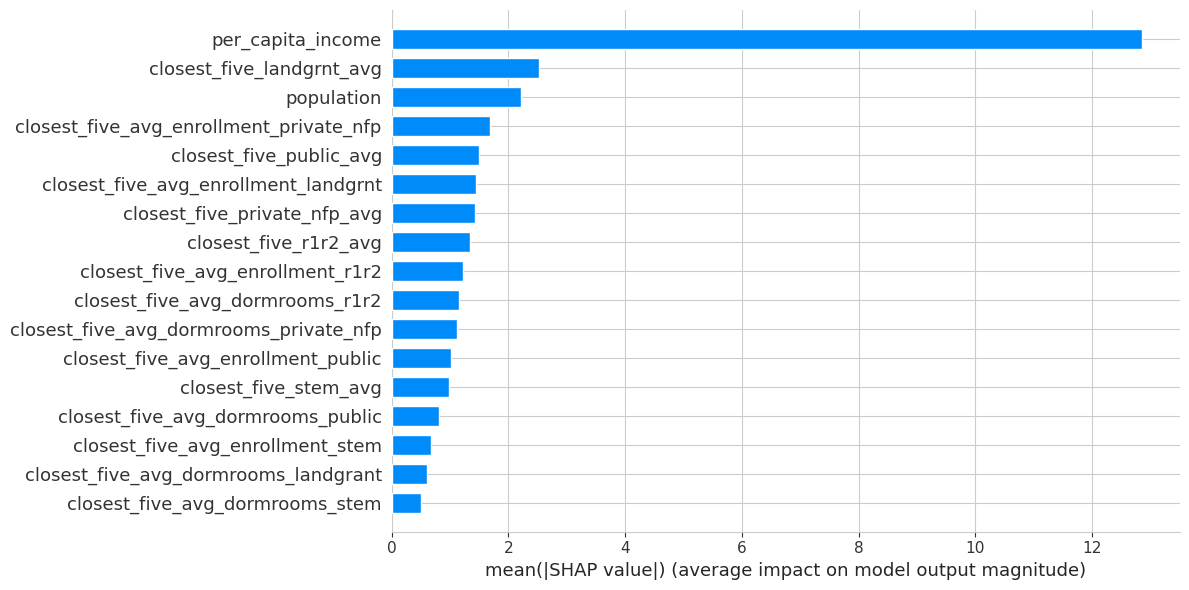

In [78]:
fig = plt.figure()
shap.summary_plot(
    shap_values, 
    X_train, 
    plot_type='bar', 
    show=False,
    plot_size=[12, 6]
)
plt.show()
with open('data/Four_states_combined_models_pickled/shap_xgb_hypertuned_bar_plot.pkl', 'wb') as f:
    pickle.dump(fig, f)
plt.close()

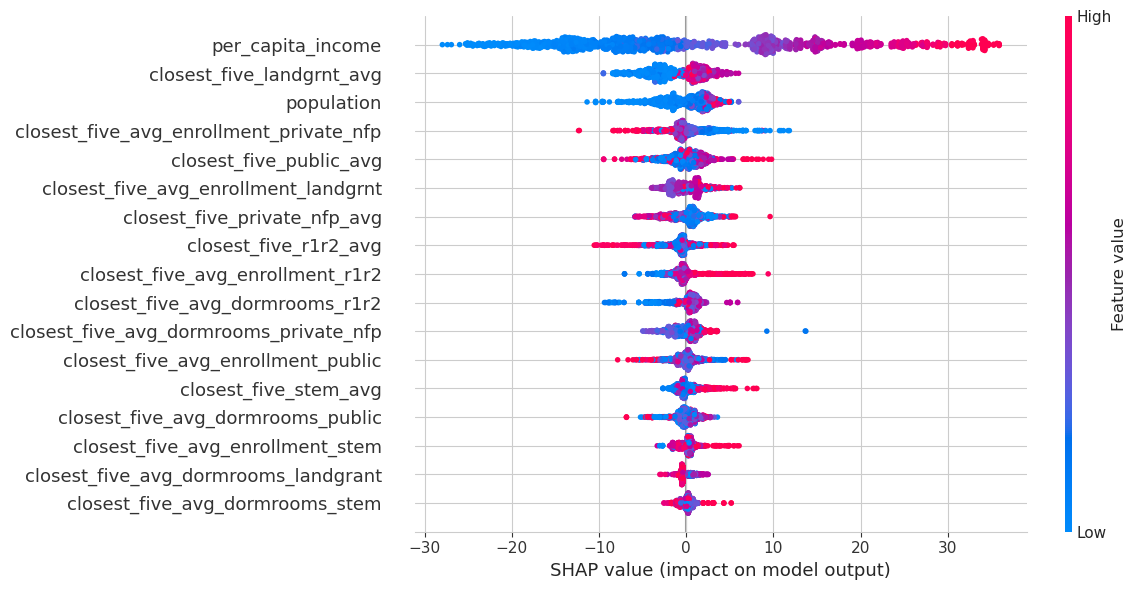

In [79]:
### the scatter plot
fig = plt.figure()
shap.summary_plot(shap_values, X_train, show=False, plot_size=[12, 6])
plt.show()
with open('data/Four_states_combined_models_pickled/shap_xgb_hypertuned_scatter_plot.pkl', 'wb') as f:
    pickle.dump(fig, f)
plt.close()

# Running the model on the testing data

In [61]:
wi_testing = pd.read_csv('data/Wisconsin/train_test_split/testing.csv')
ma_testing = pd.read_csv('data/Massachusetts/train_test_split/testing.csv')
ga_testing = pd.read_pickle('data/GA_pickled/testing.pkl')
nc_testing = pd.read_csv('data/North_Carolina/train_test_split/testing.csv')

In [62]:
ga_testing.rename(columns={'closest_five_avg_dormrooms_landgrnt':'closest_five_avg_dormrooms_landgrant','closest_five_landgrant_avg':'closest_five_landgrnt_avg','closest_five_avg_enrollment_landgrant':'closest_five_avg_enrollment_landgrnt'},inplace=True)

In [63]:
nc_testing.rename(columns={'closest_five_private_notprofit_avg':'closest_five_private_nfp_avg','County':'COUNTY'},inplace=True)

In [64]:
wi_testing=wi_testing[relevantcolumns]
ma_testing=ma_testing[relevantcolumns]
ga_testing=ga_testing[relevantcolumns]
nc_testing=nc_testing[relevantcolumns]

In [94]:
len(nc_testing.index)

200

In [95]:
len(nc_training.index)

200

In [65]:
nc_testing=nc_testing[nc_testing['PERCENT_3_OR_ABOVE'] != '*']

In [67]:
nc_testing=nc_testing.dropna()

In [96]:
testing = pd.concat([wi_testing,ma_testing,ga_testing],axis=0)

**By combining the testing data for each of the four states, we obtain the testing data for the combined model**

In [97]:
training = training.apply(pd.to_numeric, errors='coerce')

In [98]:
testing

,COUNTY,PERCENT_3_OR_ABOVE,population,per_capita_income,closest_five_r1r2_avg,closest_five_public_avg,closest_five_private_nfp_avg,closest_five_landgrnt_avg,closest_five_stem_avg,closest_five_avg_enrollment_r1r2,closest_five_avg_enrollment_public,closest_five_avg_enrollment_private_nfp,closest_five_avg_enrollment_landgrnt,closest_five_avg_enrollment_stem,closest_five_avg_dormrooms_r1r2,closest_five_avg_dormrooms_public,closest_five_avg_dormrooms_private_nfp,closest_five_avg_dormrooms_landgrant,closest_five_avg_dormrooms_stem
0,Jefferson,63.516260,84696,47305,56.513411,25.692136,21.083706,154.787748,46.737344,27064.0,19050.4,1825.6,30937.0,22189.6,5303.4,2643.4,534.0,7594.4,4480.6
1,Waushara,43.956044,24549,43781,117.003936,43.076829,49.409389,137.690816,103.671360,27064.0,10705.2,2084.0,22515.6,22189.6,5303.4,1036.2,953.2,3257.0,4480.6
2,Oneida,65.202703,37118,48517,175.279031,54.345122,107.755170,118.141501,172.229021,32411.8,3509.2,1136.8,10172.6,24446.6,5696.8,56.6,797.0,1794.2,3910.4
3,Lincoln,62.000000,28376,53038,165.715335,44.102369,104.584718,117.385571,161.474822,32411.8,5166.0,1202.8,10172.6,24446.6,5696.8,588.4,951.8,1794.2,3910.4
4,Rock,58.988764,163681,45500,59.757422,23.670589,24.512027,157.561949,54.971126,27064.0,18882.4,1110.0,30937.0,22189.6,5303.4,2643.4,455.8,7594.4,4480.6
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
161,Harris,47.843137,34914,49930,108.985623,35.508222,73.761956,139.195640,108.985623,26288.0,11941.6,1700.8,18512.8,26288.0,4834.0,1258.0,724.8,4134.0,4834.0
292,Newton,26.482618,113298,38876,55.998767,48.100749,33.236915,146.123515,55.998767,29515.6,9929.2,829.2,22160.2,29515.6,6238.8,453.2,383.4,5104.8,6238.8
110,Atkinson,25.000000,8265,30449,170.428665,52.509893,137.350078,221.001656,192.217033,23842.2,6876.4,2474.4,21696.0,27405.6,4389.8,912.2,628.4,4156.2,4772.0
289,Morgan,58.575198,20171,53448,75.532754,54.996800,60.838219,151.745826,75.532754,30647.6,17579.0,634.4,22160.2,30647.6,6417.8,2705.4,212.0,5104.8,6417.8


In [99]:
model_preds = xgb_pca_pipe.predict(testing[features])

In [100]:
root_mean_squared_error(testing['PERCENT_3_OR_ABOVE'],model_preds)

np.float64(8.667510325095487)

In [101]:
r2_score(testing['PERCENT_3_OR_ABOVE'],model_preds)

0.7998984189445254